In [2]:
import sys 
import joblib
sys.path.append('/home/samuel.varga/python_packages/wofs_ml_severe')
sys.path.append('/home/samuel.varga/python_packages/WoF_post')
sys.path.append('/home/samuel.varga/python_packages/scikit-explain')
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/experiments')
sys.path.append('/home/samuel.varga/python_packages/MontePython/')

from ml_2to6_data_pipeline import (GridPointExtracter,
                                                       subsampler, 
                                                       load_dataset, random_subsampler)
from os.path import join, exists
import argparse
#Appendages
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/')
sys.path.append('/home/samuel.varga/python_packages/ml_workflow/')
sys.path.append('/home/samuel.varga/python_packages/VargaPy/')
# Import packages 
import pandas as pd
import numpy as np
import sklearn
from os.path import join
from sklearn.linear_model import LogisticRegression
from hyperopt import hp
from main.io import load_ml_data
from ml_workflow.calibrated_pipeline_hyperopt_cv import norm_aupdc_scorer, norm_csi_scorer
from ml_workflow.tuned_estimator import TunedEstimator, dates_to_groups
from VargaPy.MlUtils import All_Severe, Drop_Unwanted_Variables, Train_Ml_Parser, group_coefs
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt

lookup_file: /home/samuel.varga/python_packages/WoF_post/wofs/data/psadilookup.dat


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Load data

In [56]:
%matplotlib inline
FRAMEWORK='POTVIN'
TIMESCALE='2to6'
target_scale='9'
train_scale=None
base_path = f'/work/samuel.varga/data/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}'
hazard='all'
X,y,metadata = All_Severe(base_path, mode='train',
                                  target_scale=target_scale,
                                  FRAMEWORK=FRAMEWORK,
                                  TIMESCALE=TIMESCALE, SigSevere=False)
X, ts_suff = Drop_Unwanted_Variables(X, original=False, training_scale=train_scale if not None else None, intrastormOnly=False, envOnly=False)

3875
7457
8097
Using new variables- dropping old 90th percentile
(1274972, 174)
all


In [57]:
namedic={'cape_ml':'ML CAPE',
'cin_ml': 'ML CIN',
'comp_dz':'Comp. Refl.',
'hailcast':'HAILCAST',
'low_level_lapse_rate': 'LL Lapse Rate',
'mid_level_lapse_rate': 'ML Lapse Rate',
'okubo_weiss': 'Okubo Weiss',
'scp': 'SCP',
'shear_u_0to1':'0-1 U Shear',
'shear_u_0to6':'0-6 U Shear',
'shear_u_3to6':'3-6 U Shear',
'shear_v_0to1':'0-1 V Shear',
'shear_v_0to6':'0-6 V Shear',
'shear_v_3to6':'3-6 V Shear',
'srh_0to3':'0-3 SRH',
'stp':'STP',
'uh_0to2_instant':'0-2 UH',
'uh_2to5_instant':'2-5 UH',
'w_up':'Max Updraft',
'ws_80':'80m Wind Speed',
'wz_0to2_instant':'0-2 Vert. Vort.',
'Init Time':'Init Time'}
categoryname={'time_avg':'environment', 'time_max':'storm'}

## Plot Coefficient Ranks

In [58]:
from skexplain.common.importance_utils import to_skexplain_importance
import skexplain
model_ind=0
base_path=f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}'
model=joblib.load(join(base_path, f'mlModels/{target_scale}km/Varga_{train_scale+"km" if train_scale is not None else "all"}_logistic_{hazard}_{target_scale}km_control_{model_ind}.joblib'))

# X and y are the training dataset
explainer = skexplain.ExplainToolkit(X=X,y=y)
coefs = model['model'].calibrated_classifiers_[0].base_estimator.named_steps['model'].coef_[0]

In [59]:
Z=group_coefs(X.columns, coefs)
if '4km' in Z.category.values:
    copy = Z.copy()
    bad_ind=copy.category.values=='4km'
    sub=Z.category.values[bad_ind]
    sub2=Z.neighborhood.values[bad_ind]
    sub3=Z.statistic.values[bad_ind]
    copy.category.values[bad_ind]=sub3
    copy.neighborhood.values[bad_ind]=sub
    copy.statistic.values[bad_ind]=sub2
    Z=copy.copy()
Z=Z.groupby(['neighborhood','category']).sum().reset_index() #variable, category, neighborhood, statistic
Z.sort_values(by='coef', ascending=False)

,neighborhood,category,coef
2,45km,time_avg,9.550045
4,9km,time_avg,5.096278
0,27km,time_avg,4.618638
3,45km,time_max,3.782846
5,9km,time_max,2.166022
1,27km,time_max,1.295422


In [60]:
if 'variable' in Z.columns:
    Z.variable=list(map(namedic.get, Z.variable))
    names=np.array(Z.variable + ' ' + Z.neighborhood)#'_'+Z.neighborhood)
    names=np.array(Z.neighborhood)
if 'category' in Z.columns:
    Z.category=list(map(categoryname.get, Z.category))

names=Z[Z.columns[:-1:]].astype(str).agg(' '.join, axis=1)
coefs_=np.array(Z.coef)

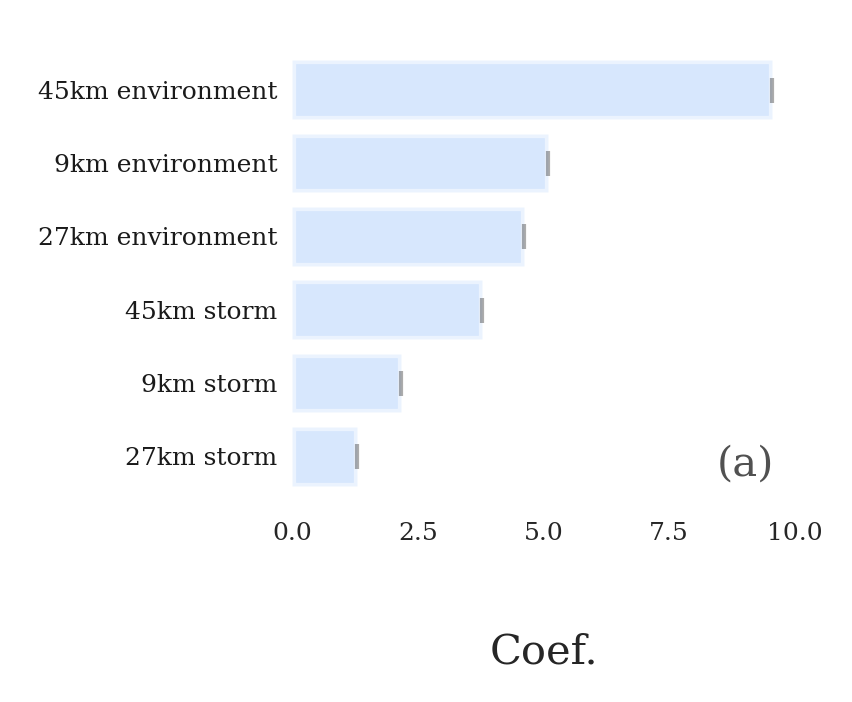

In [61]:
coef_rank = to_skexplain_importance(coefs_,
                                       estimator_name='LogisticRegression', 
                                       feature_names=names, 
                                        method = 'coefs', normalize=False)

panels = [('coefs', 'LogisticRegression')]
fig = explainer.plot_importance(data=coef_rank, panels=panels, 
                                num_vars_to_plot=20, 
                               )

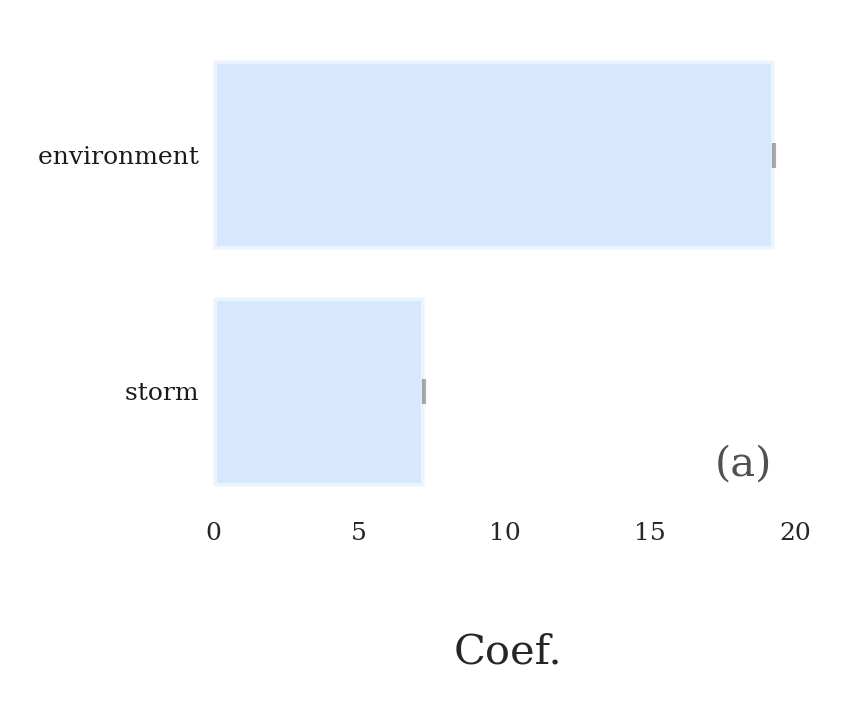

In [62]:
Z=group_coefs(X.columns, coefs)
if '4km' in Z.category.values:
    copy = Z.copy()
    bad_ind=copy.category.values=='4km'
    sub=Z.category.values[bad_ind]
    sub2=Z.neighborhood.values[bad_ind]
    sub3=Z.statistic.values[bad_ind]
    copy.category.values[bad_ind]=sub3
    copy.neighborhood.values[bad_ind]=sub
    copy.statistic.values[bad_ind]=sub2
    Z=copy.copy()
Z=Z.groupby(['category']).sum().reset_index() #variable, category, neighborhood, statistic
#Z.sort_values(by='coef', ascending=False)
if 'variable' in Z.columns:
    Z.variable=list(map(namedic.get, Z.variable))
    names=np.array(Z.variable + ' ' + Z.neighborhood)#'_'+Z.neighborhood)
    names=np.array(Z.neighborhood)
if 'category' in Z.columns:
    Z.category=list(map(categoryname.get, Z.category))

names=Z[Z.columns[:-1:]].astype(str).agg(' '.join, axis=1)
coefs_=np.array(Z.coef)
coef_rank = to_skexplain_importance(coefs_,
                                       estimator_name='LogisticRegression', 
                                       feature_names=names, 
                                        method = 'coefs', normalize=False)

panels = [('coefs', 'LogisticRegression')]
fig = explainer.plot_importance(data=coef_rank, panels=panels, 
                                num_vars_to_plot=20, 
                               )

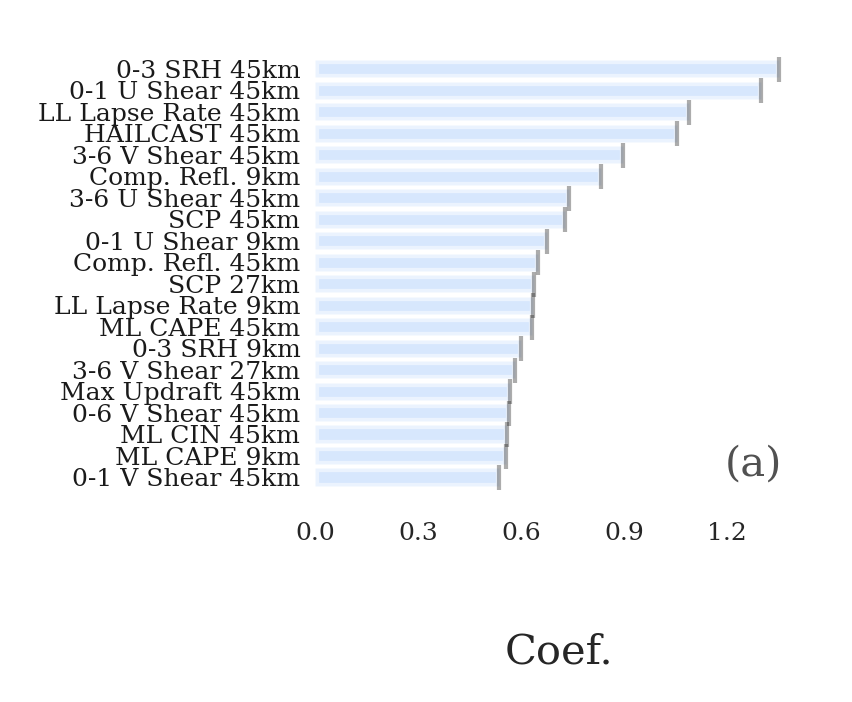

In [63]:
Z=group_coefs(X.columns, coefs)
if '4km' in Z.category.values:
    copy = Z.copy()
    bad_ind=copy.category.values=='4km'
    sub=Z.category.values[bad_ind]
    sub2=Z.neighborhood.values[bad_ind]
    sub3=Z.statistic.values[bad_ind]
    copy.category.values[bad_ind]=sub3
    copy.neighborhood.values[bad_ind]=sub
    copy.statistic.values[bad_ind]=sub2
    Z=copy.copy()
Z=Z.groupby(['variable','neighborhood']).sum().reset_index() #variable, category, neighborhood, statistic
#Z.sort_values(by='coef', ascending=False)
if 'variable' in Z.columns:
    Z.variable=list(map(namedic.get, Z.variable))
    names=np.array(Z.variable + ' ' + Z.neighborhood)#'_'+Z.neighborhood)
    names=np.array(Z.neighborhood)
if 'category' in Z.columns:
    Z.category=list(map(categoryname.get, Z.category))

names=Z[Z.columns[:-1:]].astype(str).agg(' '.join, axis=1)
coefs_=np.array(Z.coef)
coef_rank = to_skexplain_importance(coefs_,
                                       estimator_name='LogisticRegression', 
                                       feature_names=names, 
                                        method = 'coefs', normalize=False)

panels = [('coefs', 'LogisticRegression')]
fig = explainer.plot_importance(data=coef_rank, panels=panels, 
                                num_vars_to_plot=20, 
                               )

(0.0, 2.0)

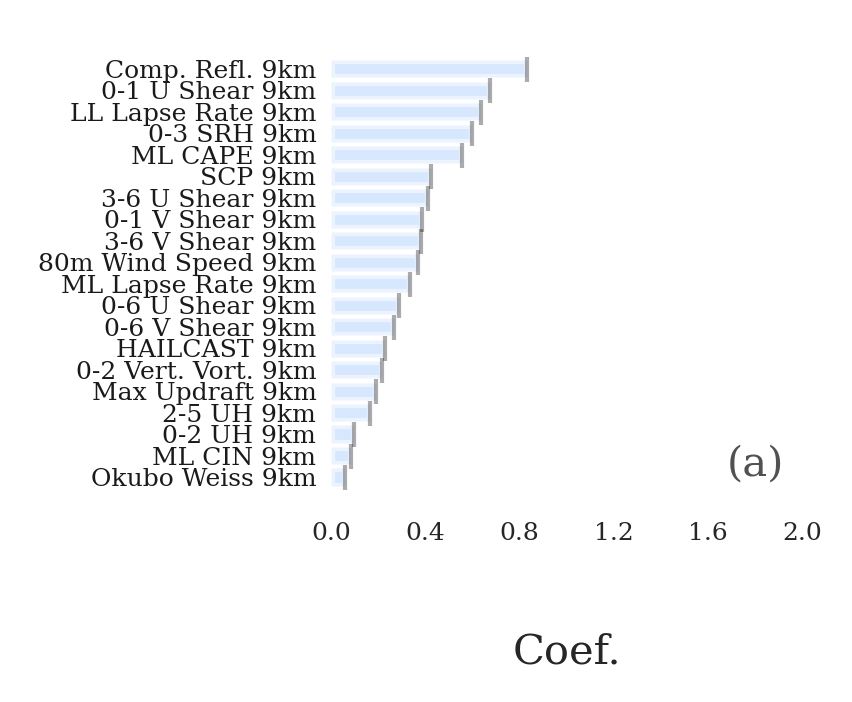

In [66]:
Z=group_coefs(X.columns, coefs)
Z=Z.groupby(['variable','neighborhood']).sum().reset_index() #variable, category, neighborhood, statistic
#Z.sort_values(by='coef', ascending=False)
if 'variable' in Z.columns:
    Z.variable=list(map(namedic.get, Z.variable))
    names=np.array(Z.variable + ' ' + Z.neighborhood)#'_'+Z.neighborhood)
    names=np.array(Z.neighborhood)
if 'category' in Z.columns:
    Z.category=list(map(categoryname.get, Z.category))

names=Z[Z.columns[:-1:]].astype(str).agg(' '.join, axis=1)
coefs_=np.array(Z.coef)
coef_rank = to_skexplain_importance(coefs_[Z.neighborhood=='9km'],
                                       estimator_name='LogisticRegression', 
                                       feature_names=names[Z.neighborhood=='9km'], 
                                        method = 'coefs', normalize=False)

panels = [('coefs', 'LogisticRegression')]
fig = explainer.plot_importance(data=coef_rank, panels=panels, 
                                num_vars_to_plot=20, 
                               )
fig[1].set_xlim(0,2)

## Grouped Feature Importance

In [ ]:
#dir(model['model'])

In [ ]:
#model['model'].get_params()

In [88]:
#model['model'].calibrated_classifiers_[0].base_estimator.named_steps['model'].coef_[0]

In [89]:
#Z.groupby(['neighborhood','category']).sum().reset_index()
#print(x.coef.sum())

In [90]:
#Z.groupby(['category']).sum().reset_index()

In [91]:
#print(sum(np.abs(coefs)))